<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>
    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">
            <tr>
                <td  style="border: none!important;">
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                <h1 align=center><font size=5 color="#045F5F"> <b>Natural Language Processing (Spring 2023)</b><br><br>CA2-Q3</i></font></h1>
                </td>
                <td style="border: none!important;">
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
            </tr>
        </table>
    
</div>
<br>
<font size=3 color="#045F5F">Parham Bicharanlu<br></font><br>
<font size=3 color="#045F5F">810100303<br></font><br>

# Read in dataset

In [ ]:
# read in the extracted text file      
with open('/kaggle/input/shefe/t8.shakespeare.txt', "r") as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

# Preprocesing Text Data
* Lowercasing all text
* Replacing all punctuation marks with tokens to use in the model
* Removing words with 5 or fewer occurrences using Counter class.

In [49]:
import re
from collections import Counter


def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace(".", " <PERIOD> ")
    text = text.replace(",", " <COMMA> ")
    text = text.replace('"', " <QUOTATION_MARK> ")
    text = text.replace(";", " <SEMICOLON> ")
    text = text.replace("!", " <EXCLAMATION_MARK> ")
    text = text.replace("?", " <QUESTION_MARK> ")
    text = text.replace("(", " <LEFT_PAREN> ")
    text = text.replace(")", " <RIGHT_PAREN> ")
    text = text.replace("--", " <HYPHENS> ")
    text = text.replace("?", " <QUESTION_MARK> ")
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(":", " <COLON> ")
    words = text.split()

    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words



In [50]:
words = preprocess(text)
print(words[:30])

['this', 'is', 'the', 'etext', 'file', 'presented', 'by', 'project', 'gutenberg', '<COMMA>', 'and', 'is', 'presented', 'in', 'with', 'world', 'library', '<COMMA>', 'inc', '<PERIOD>', '<COMMA>', 'from', 'their', 'library', 'of', 'the', 'future', 'and', 'shakespeare', '<PERIOD>']


In [51]:
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 1062517
Unique words: 8038


# Skip-gram

Creating Lookup Tables for Vocabulary.

In [52]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: Two dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [53]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[24, 14, 2, 432, 3676, 3677, 34, 418, 452, 0, 3, 14, 3677, 12, 18, 134, 454, 0, 471, 1, 0, 53, 70, 454, 6, 2, 3817, 3, 382, 1]


Subsampling frequent words.

In [54]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[3676, 3677, 418, 3677, 452, 6646, 5391, 1578, 494, 418, 478, 37, 205, 489, 444, 490, 309, 22, 2393, 5736, 2202, 4587, 596, 1578, 454, 2631, 24, 444, 3234, 7229]


Function to Get Target Words.

In [55]:
def get_target(words, idx, window_size=2):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [56]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=2)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [4, 6]


Generating Word Batches for a Skip-gram Model.

In [57]:
def get_batches(words, batch_size, window_size=2):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [58]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=2))

print('x\n', x)
print('y\n', y)

x
 [0, 1, 1, 1, 2, 2, 2, 3]
y
 [1, 0, 2, 3, 0, 1, 3, 2]


Calculates the cosine similarity.

In [59]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

In [60]:
import torch
from torch import nn
import torch.optim as optim

Word Embedding with Skip-Gram Negative Sampling Model.

In [61]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        # define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        # Initialize embedding tables with uniform distribution
        # I believe this helps with convergence
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        
    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors
    
    def forward_output(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors
        
    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        
        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)
        
        noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)
        
        return noise_vectors

Negative Sampling Loss Module for Skip-Gram Model.

In [62]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        batch_size, embed_size = input_vectors.shape
        
        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        
        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        # bmm = batch matrix multiplication
        # correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        # incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # negate and sum correct and noisy log-sigmoid losses
        # return average batch loss
        return -(out_loss + noise_loss).mean()

Training Word Embeddings using Skip-Gram with Negative Sampling in PyTorch.

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
# Using word frequencies calculated earlier in the notebook
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# instantiating the model
embedding_dim = 100
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 150
steps = 0
epochs = 20

# train for some number of epochs
for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, output, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 4)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/20
Loss:  6.585720539093018
let | owes, such, troyan, commonweal, upon't
then | keeper, thereto, neglected, quince, anchor
not | coat, warder, cover, malice, dastard
love | to's, dusky, steep, slaughter'd, dial
am | odd, scruple, aged, parcels, brutus
shall | warm, seconds, notwithstanding, obscur'd, thus
we | advocate, rabble, but, truce, cowards
why | gives, fabian, field, flattering, turn'd
princes | caesar's, opinion, boldness, tree, vanish
forget | sour, anguish, starts, sounded, shin
troy | stratagem, then-, greyhound, resemble, christians
takes | pawn, guilty, peril, [reads, regards
escalus | precepts, scar'd, amaz'd, righteous, willing
drum | sounded, ghosts, madame, commandment, curtsy
fine | pluck'd, ev'ry, measures, each, cross'd
wert | hardness, brakenbury, purpos'd, shepherds, following
...

Epoch: 1/20
Loss:  5.928306579589844
my | meant, ourself, pray'rs, sounds, sworn
not | coat, dastard, cover, malice, from
them | break, holding, grow, factious, executioners
i

In [64]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

Combining embedding and Context Weights.

In [65]:
embeddings = model.in_embed.weight.to('cpu').data.numpy() + model.out_embed.weight.to('cpu').data.numpy()


# Embeddings-Visualization

Principal Component Analysis (PCA) for visualizing word embeddings.

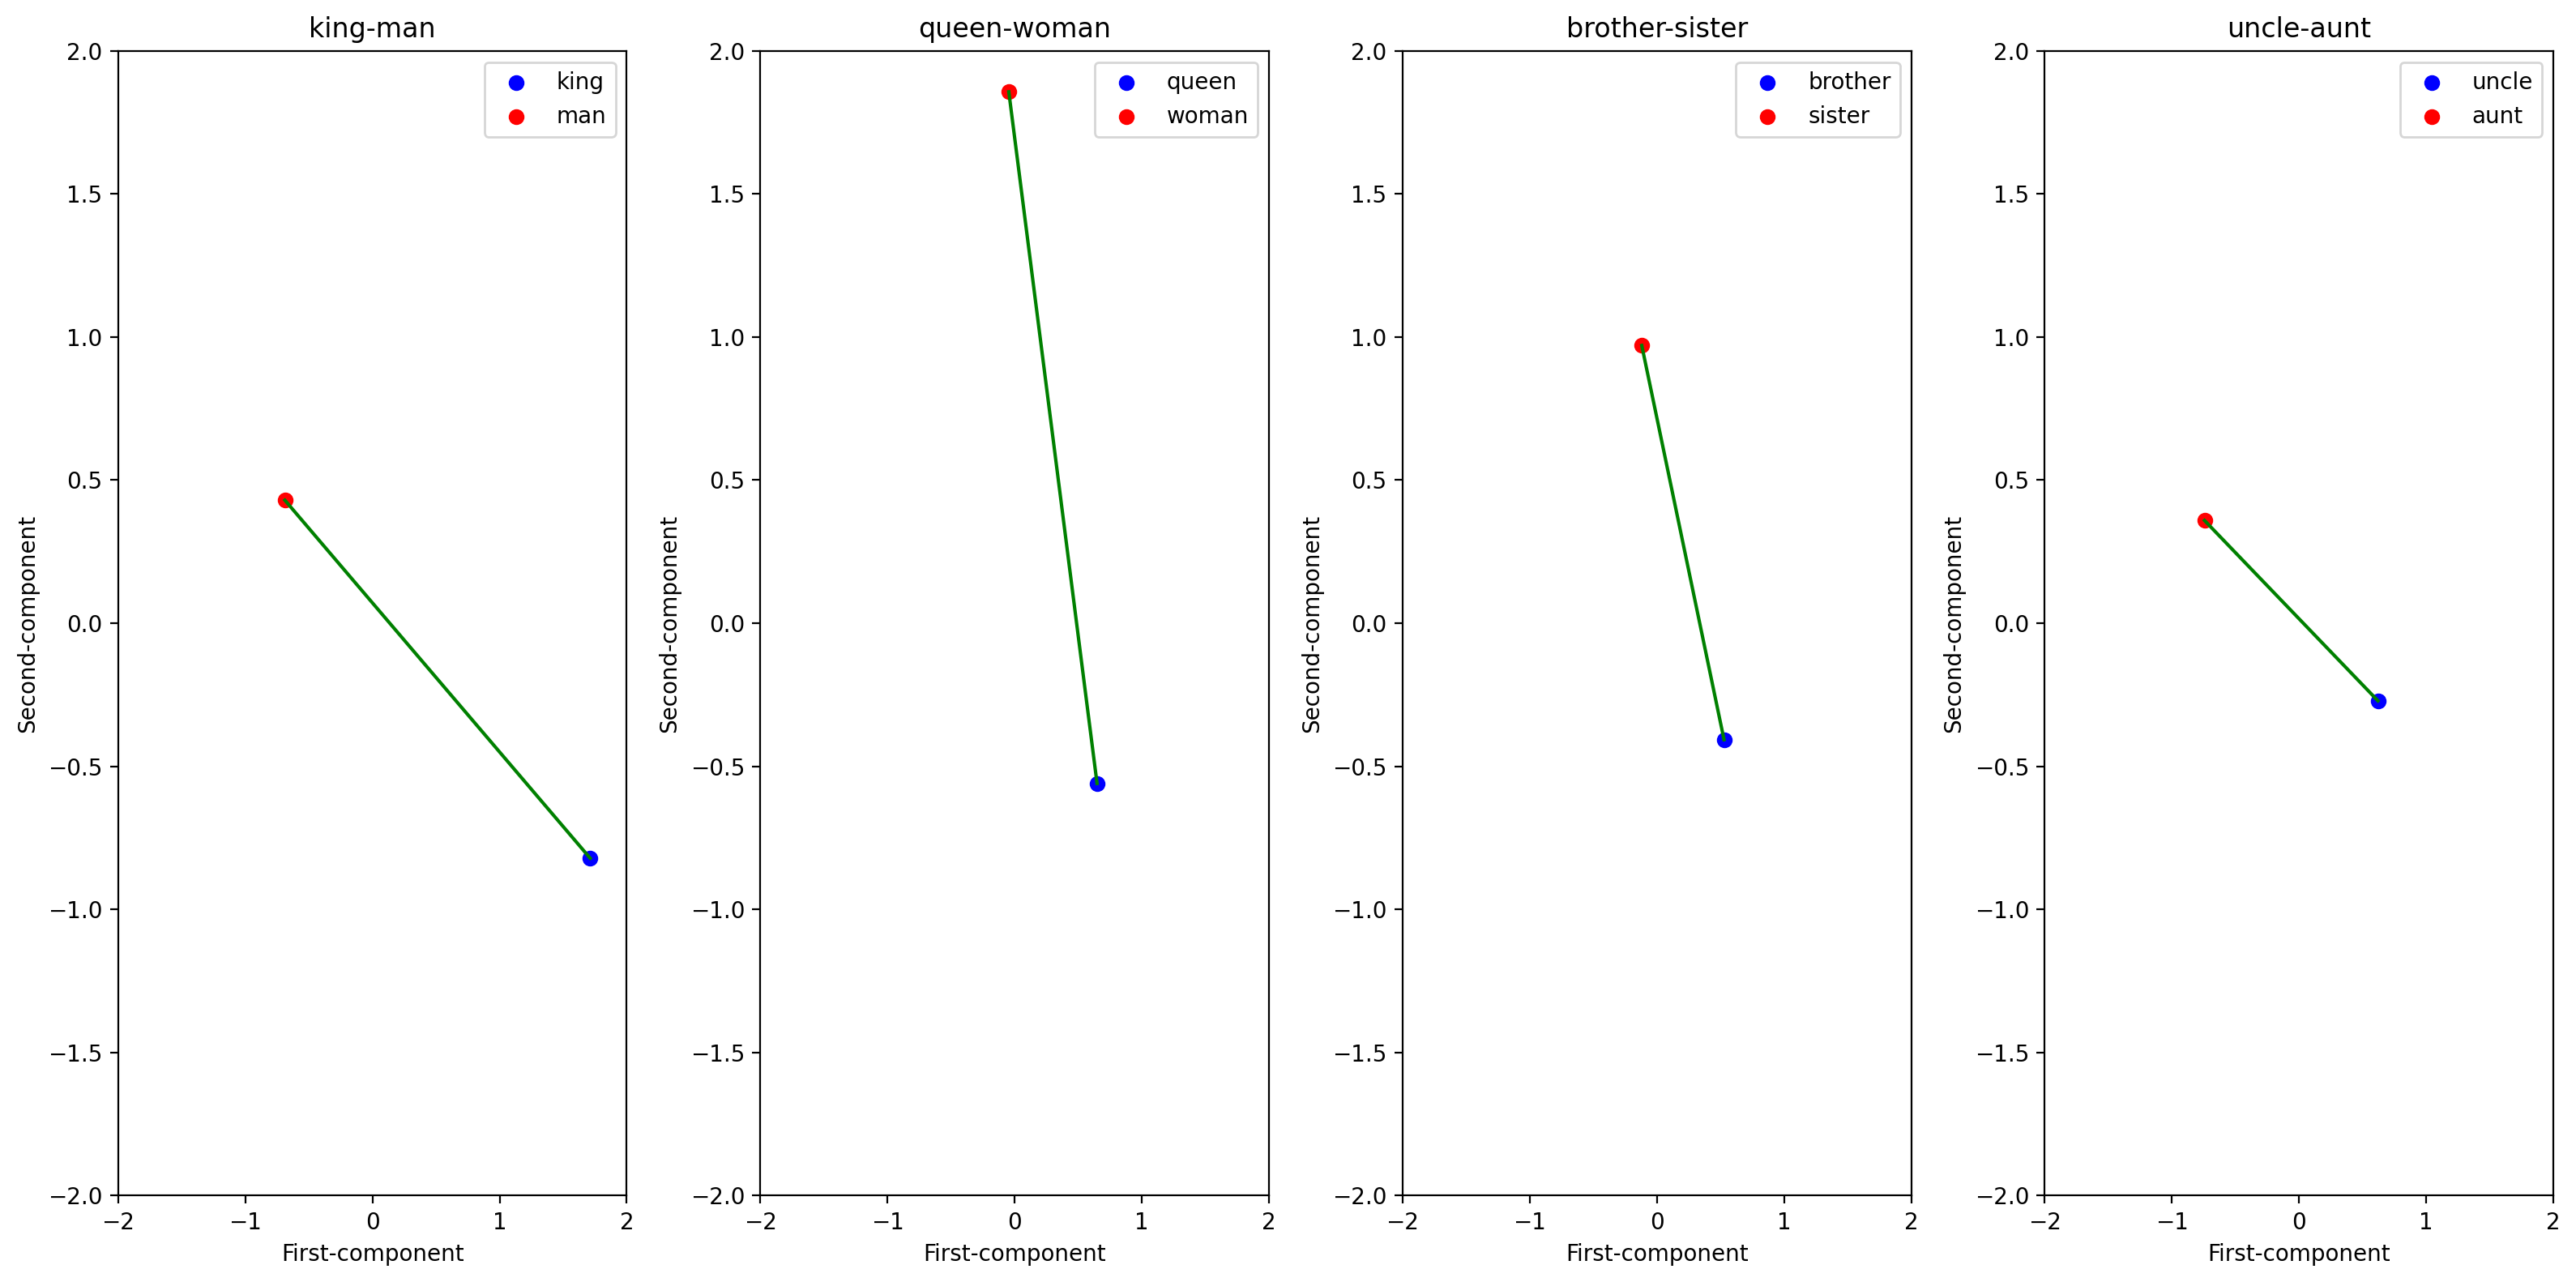

In [106]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# create a PCA object with 2 components
pca = PCA(n_components=2)

# fit the word vectors to the PCA object
word_vectors_pca = pca.fit_transform(embeddings)

# create a dictionary of the four vector pairs
vector_pairs = {'king-man': ('king', 'man'), 
                'queen-woman': ('queen', 'woman'), 
                'brother-sister': ('brother', 'sister'), 
                'uncle-aunt': ('uncle', 'aunt')}

# create four subplots, each on a separate row
fig, axs = plt.subplots(1, 4, figsize=(16, 8))

# create a plot for each vector pair
for i, (pair_name, (w1, w2)) in enumerate(vector_pairs.items()):
    # find the vector difference
    diff = embeddings[vocab_to_int[w1]] - embeddings[vocab_to_int[w2]]
    
    # transform the difference vector to 2D using PCA
    diff_pca = pca.transform(diff.reshape(1, -1))
    
    # scatter plot the word vectors
    
    # plot the two words with different colors
    w1_idx, w2_idx = vocab_to_int[w1], vocab_to_int[w2]
    axs[i].scatter(word_vectors_pca[w1_idx,0], word_vectors_pca[w1_idx,1], color='blue', label=w1)
    axs[i].scatter(word_vectors_pca[w2_idx,0], word_vectors_pca[w2_idx,1], color='red', label=w2)
    
    # plot the vector difference
    #axs[i].arrow(word_vectors_pca[w2_idx,0], word_vectors_pca[w2_idx,1], 
                 #diff_pca[0,0], diff_pca[0,1], color='green', width=0.03, alpha=0.5)
    axs[i].plot([word_vectors_pca[w1_idx,0],word_vectors_pca[w2_idx,0]],[word_vectors_pca[w1_idx,1],word_vectors_pca[w2_idx,1]],color='green')
    # set limits of x and y axes to the same values for all subplots
    xlim = (-2, 2)
    ylim = (-2, 2)
    axs[i].set_xlim(xlim)
    axs[i].set_ylim(ylim)
    
    # add labels and title
    axs[i].set_xlabel('First-component')
    axs[i].set_ylabel('Second-component')
    axs[i].set_title(pair_name)
    axs[i].legend()

plt.tight_layout()
plt.savefig('embedding.png')
plt.show()




Visualized words.

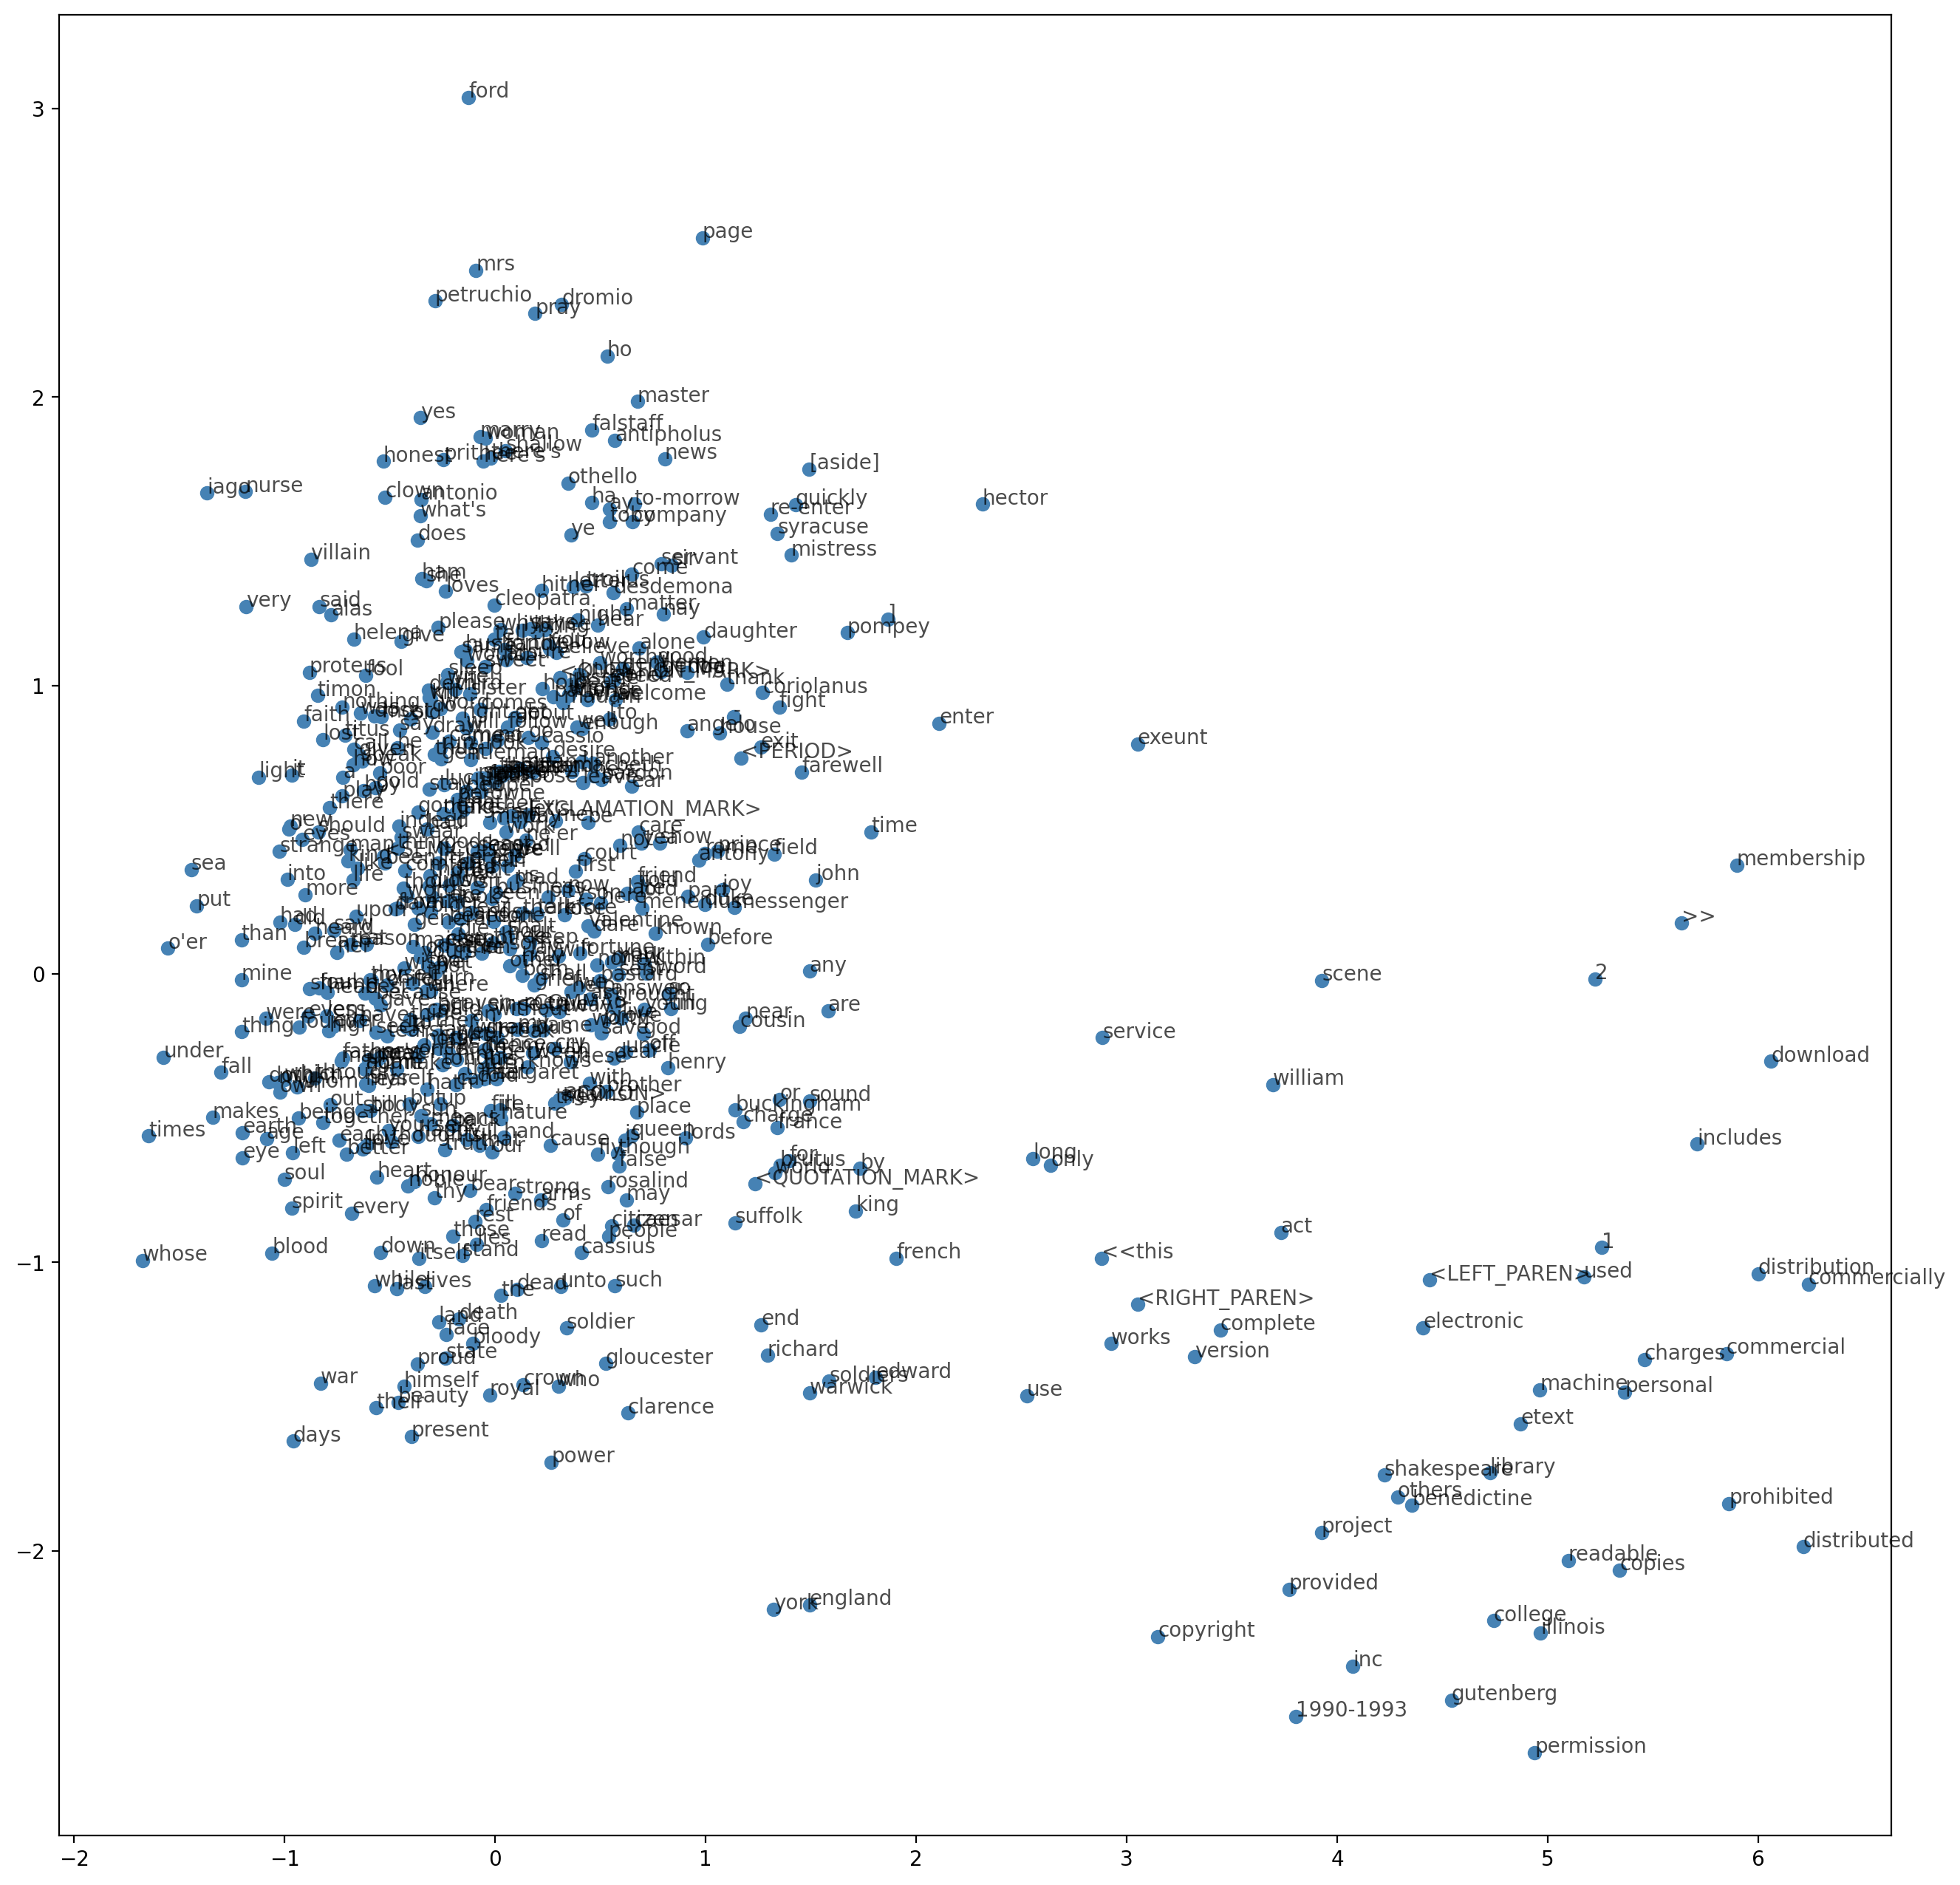

In [108]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*word_vectors_pca[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (word_vectors_pca[idx, 0], word_vectors_pca[idx, 1]), alpha=0.7)

plt.savefig('plots.png')
plt.show()